In [52]:
import numpy as np
import math
import networkx as nx

import torch
from torch.nn.parameter import Parameter
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [53]:
G = nx.Graph()
blue, orange, green = "#1f77b4", "#ff7f0e", "#2ca02c"
G.add_nodes_from([(1, {"color": blue}), (2, {"color": orange}), (3, {"color": blue}), (4, {"color": green})])
G.add_edges_from([(1, 2), (2, 3), (1, 3), (3, 4)])
A = np.asarray(nx.adjacency_matrix(G).todense())
A

array([[0, 1, 1, 0],
       [1, 0, 1, 0],
       [1, 1, 0, 1],
       [0, 0, 1, 0]])

In [54]:
def build_graph_color_label_representation(G, mapping_dict):
    one_hot_idxs = np.array([mapping_dict[v] for v in nx.get_node_attributes(G, 'color').values()])
    one_hot_encoding = np.zeros((one_hot_idxs.size, len(mapping_dict)))
    one_hot_encoding[np.arange(one_hot_idxs.size), one_hot_idxs] = 1
    return one_hot_encoding

In [55]:
X = build_graph_color_label_representation(G, {green: 0, blue: 1, orange: 2})
X

array([[0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.]])

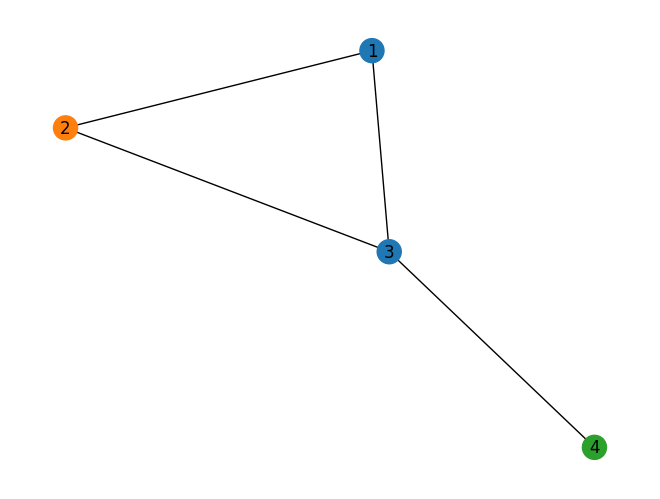

In [56]:
color_map = nx.get_node_attributes(G, 'color').values()
nx.draw(G, with_labels=True, node_color=color_map)

In [57]:
f_in, f_out = X.shape[1], 6
W_1 = np.random.rand(f_in, f_out)
W_2 = np.random.rand(f_in, f_out)
h = np.dot(X, W_1) + np.dot(np.dot(A, X), W_2)

In [58]:
class NodeNetwork(torch.nn.Module):
    def __init__(self, input_features):
        super().__init__()
        self.conv_1 = BasicGraphConvolutionLayer(input_features, 32)
        self.conv_2 = BasicGraphConvolutionLayer(32, 32)
        self.fc_1 = torch.nn.Linear(32, 16)
        self.out_layer = torch.nn.Linear(16, 2)

    def forward(self, X, A, batch_mat):
        x = F.relu(self.conv_1(X, A))
        x = F.relu(self.conv_2(x, A))
        output = global_sum_pool(x, batch_mat)
        output = self.fc_1(output)
        output = self.out_layer(output)
        return F.softmax(output, dim=1)

class BasicGraphConvolutionLayer(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.W2 = Parameter(torch.rand((in_channels, out_channels), dtype=torch.float32))
        self.W1 = Parameter(torch.rand((in_channels, out_channels), dtype=torch.float32))
        self.bias = Parameter(torch.zeros(out_channels, dtype=torch.float32))

    def forward(self, X, A):
        potential_msgs = torch.mm(X, self.W2)
        propagated_msgs = torch.mm(A, potential_msgs)
        root_update = torch.mm(X, self.W1)
        output = propagated_msgs + root_update + self.bias
        return output

def global_sum_pool(X, batch_mat):
    if batch_mat is None or batch_mat.dim() == 1:
        return torch.sum(X, dim=0).unsqueeze(0)
    else:
        return torch.mm(batch_mat, X)

In [59]:
X.shape, A.shape

((4, 3), (4, 4))

In [60]:
basiclayer = BasicGraphConvolutionLayer(3, 8)
out = basiclayer(X=torch.tensor(X, dtype=torch.float32), A=torch.tensor(A, dtype=torch.float32))
out.shape

torch.Size([4, 8])

In [61]:
def get_batch_tensor(graph_sizes):
    starts = [sum(graph_sizes[:idx]) for idx in range(len(graph_sizes))]
    stops = [starts[idx] + graph_sizes[idx] for idx in range(len(graph_sizes))]
    tot_len = sum(graph_sizes)
    batch_size = len(graph_sizes)

    batch_mat = torch.zeros([batch_size, tot_len]).float()
    for idx, starts_and_stops in enumerate(zip(starts, stops)):
        start = starts_and_stops[0]
        stop = starts_and_stops[1]
        batch_mat[idx, start:stop] = 1
    return batch_mat

def collate_graphs(batch):
    adj_mats = [graph['A'] for graph in batch]
    sizes = [A.size(0) for A in adj_mats]
    tot_size = sum(sizes)
    batch_mat = get_batch_tensor(sizes)
    feat_mats = torch.cat([graph['X'] for graph in batch], dim=0)
    labels = torch.cat([graph['y'] for graph in batch], dim=0)

    batch_adj = torch.zeros([tot_size, tot_size], dtype=torch.float32)
    accum = 0
    for adj in adj_mats:
        g_size = adj.shape[0]
        batch_adj[accum: accum + g_size, accum: accum + g_size] = adj
        accum += g_size

    repr_and_label = {'A': batch_adj, 'X': feat_mats, 'y': labels, 'batch': batch_mat}
    return repr_and_label

In [62]:
def get_graph_dict(G, mapping_dict):
    A = torch.from_numpy(np.asarray(nx.adjacency_matrix(G).todense())).float()
    X = torch.from_numpy(build_graph_color_label_representation(G, mapping_dict)).float()
    y = torch.tensor([[1.0]]).float()
    return {'A': A, 'X': X, 'y': y, 'batch': None}

In [63]:
mapping_dict = {green: 0, blue: 1, orange: 2}
G1 = nx.Graph()
G1.add_nodes_from([(1, {'color': blue}), (2, {'color': orange}), (3, {'color': blue}), (4, {'color': green})])
G1.add_edges_from([(1, 2), (2, 3), (1, 3), (3, 4)])

G2 = nx.Graph()
G2.add_nodes_from([(1, {'color': green}), (2, {'color': green}), (3, {'color': orange}), (4, {'color': orange}), (5, {'color': blue})])
G2.add_edges_from([(2, 3), (3, 4), (3, 1), (5, 1)])

G3 = nx.Graph()
G3.add_nodes_from([(1, {'color': orange}), (2, {'color': orange}), (3, {'color': green}), (4, {'color': green}), (5, {'color': blue}), (6, {'color': orange})])
G3.add_edges_from([(2, 3), (3, 4), (3, 1), (5, 1), (2, 5), (6, 1)])

G4 = nx.Graph()
G4.add_nodes_from([(1, {'color': blue}), (2, {'color': blue}), (3, {'color': green})])
G4.add_edges_from([(1, 2), (2, 3)])

graph_list = [get_graph_dict(graph, mapping_dict) for graph in [G1, G2, G3, G4]]

In [64]:
class ExampleDataset(Dataset):
    def __init__(self, graph_list):
        self.graphs = graph_list

    def __len__(self):
        return len(self.graphs)

    def __getitem__(self, index):
        mol_rep = self.graphs[index]
        return mol_rep

In [65]:
dset = ExampleDataset(graph_list)
loader = DataLoader(dset, batch_size=2, shuffle=False, collate_fn=collate_graphs)

In [66]:
node_features = 3
net = NodeNetwork(node_features)
batch_result = []
for b in loader:
    batch_result.append(net(b['X'], b['A'], b['batch']).detach())

G1_rep = dset[1]
G1_single = net(G1_rep['X'], G1_rep['A'], G1_rep['batch']).detach()

G1_batch = batch_result[0][1]
torch.all(torch.isclose(G1_single, G1_batch))

tensor(True)